In [2]:
words = open("names.txt").read().splitlines()

In [3]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [5]:
min(len(w) for w in words)

2

In [6]:
max(len(w) for w in words)

15

In [7]:
b = {}
for w in words:
    chr = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chr, chr[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
        

In [8]:
sorted(b.items(), key = lambda a: -a[1])

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '.'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('.', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '.'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('.', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('.', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('.', 'l'), 1572),
 (('.', 'c'), 1542),
 (('.', 'e'), 1531),
 (('j', 'a'), 1473),
 (('r', '.'), 1377),
 (('n', 'e'),

In [9]:
import torch

In [10]:
N = torch.zeros([27,27], dtype=torch.int32)

In [11]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0


In [12]:
itos = {i:s for s, i in stoi.items()}

### Counts of bigrams

In [13]:
for w in words:
    chr = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chr, chr[1:]):
        N[stoi[ch1], stoi[ch2]] += 1
        

### Probability of bigrams

In [14]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [15]:
P = (N+1).float() 
P /= P.sum(1, keepdim=True)  # Broadcasting rules apply here 
P[0].sum()

tensor(1.)

In [184]:
g = torch.Generator().manual_seed(2147483647)
starting_t=0
for i in range(20):
    out = []
    ix = starting_t
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if (ix == 0):
            break
    print(itos[starting_t]+''.join(out))

.junide.
.janasah.
.p.
.cony.
.a.
.nn.
.kohin.
.tolian.
.juee.
.ksahnaauranilevias.
.dedainrwieta.
.ssonielylarte.
.faveumerifontume.
.phynslenaruani.
.core.
.yaenon.
.ka.
.jabdinerimikimaynin.
.anaasn.
.ssorionsush.


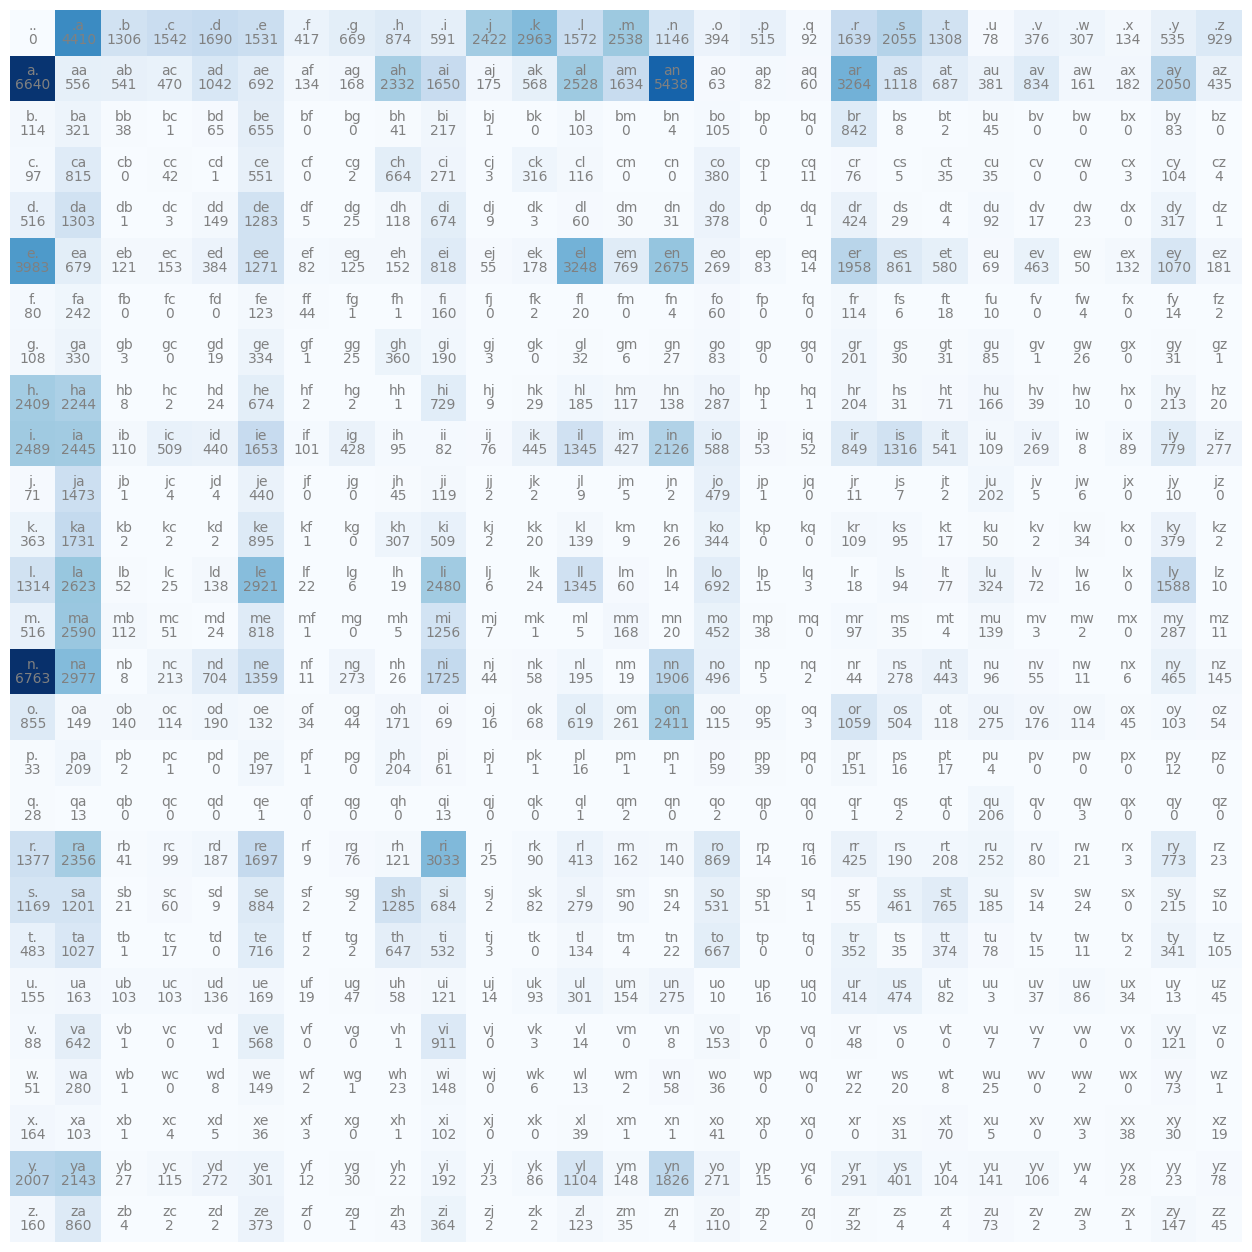

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        plt.text(j, i, itos[i]+itos[j], ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')

plt.axis('off');

Likelihood is the product of the probabilities of the bigrams.
But these product becomes too small to handle, and we use
log likelihood to make it more manageable.

In [39]:
log_likelihood = 0.0
n = 0

for w in words[:1]:
# for w in ['qjishnu']:
    chr = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chr, chr[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2} {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood / n
print(f'{nll=}')

log_likelihood=tensor(-12.5716)
nll=tensor(2.5143)


GOAL: To maximize likelihood w.r.t model parameter\
$\equiv$ maximize log likelihood\
$\equiv $ minimize negative log likelihood\
$\equiv $ maximize the average of negative log likelihood

### Creating training set

carefull about the apis used\
_e.g._ Tensor() and tensor()\
*Tensor()*- auomatically converts the type to float32\
*tensor()*- uses the data type provided 

In [19]:
xs, ys = [], []

for w in words[:1]:
    chr = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chr, chr[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)


. e
e m
m m
m a
a .


Using integers as inputs to Neurons are not very useful\
Here we use => one hot encoding\
*one hot encoding* - 0s and 1s

In [35]:
xs

tensor([ 0,  5, 13, 13,  1])

In [36]:
ys

tensor([ 5, 13, 13,  1,  0])

In [22]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

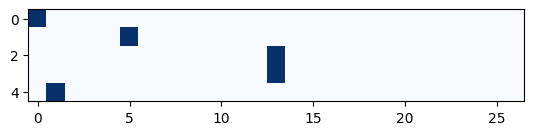

In [23]:
plt.imshow(xenc, cmap='Blues')

(5, 27) @ (27, 27)

In [34]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)
(xenc @ W)

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00],
        [ 4.7236e-01,  1.4830e+00,  3.1748e-01,  1.0588e+00,  2.3982e+00,
          4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01,
          5.5570e-01,  4.7458e-01, -1.3867e+00,  1.6229e+00,  1.7197e-01,
          9.8846e-01,  5.0657e-01,  1.0198e+00, -1.9062e+00, -4.2753e-01,
         -2.1259e+00,  9.6041e-01],
        [ 1.9359e-01,  1.0532e+00,  6.3393e-01,  2.5786e-01,  9.6408e-01,
         -2.4855e-01,  2.4756e-02, -3.0404e-02,  1.5622e+00, -4.4852e-01,
         -1.2345e+00,  1.1220e+00, -6.73

The model is not good at directly providing the probability of the next character\
The model is also not great at giving a count distribution\
We use the logcount, and when we need the count we just exponentiate it\
so its log counts (logits), and the counts are just exponentiated logits

In [25]:
logits = (xenc @ W)
counts = logits.exp()  # equivalent to N   |  softmax
probs = counts / counts.sum(1, keepdim=True)  # softmax
probs


tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

In [26]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.

### Optimisation

In [86]:
print(f'{xs=}\n{ys=}')

xs=tensor([ 0,  5, 13, 13,  1])
ys=tensor([ 5, 13, 13,  1,  0])


In [106]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

Here `xs` is the input and `ys` is the label (desired prediction)\
`xenc` is the one hot encoding of the input\
`logits` is the model output\
our abstraction allows us to see the model output as a log(counts)\
 **NOTE**: we can also assume it to be probability or any other abstraction\
`counts` is the count distribution, which is equalant to the `N`\
`probs` is the probability distribution calculated from the count distribution

In [119]:
# Forward bias

xenc = F.one_hot(xs, num_classes=27).float()
logits = (xenc @ W)
counts = logits.exp()  # equivalent to N   |  softmax
probs = counts / counts.sum(1, keepdim=True)  # softmax
loss = -probs[torch.arange(5), ys].log().mean()

Here we need to calculate the loss\
and we use classification (and not regression)\
the loss is the negative log likelihood\
and we need to minimize the loss\

### Backward pass

In [120]:
loss.item()

3.6891887187957764

In [121]:
W.grad= None
loss.backward()
W.data += -0.1 * W.grad

In [144]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [153]:
# gradient descent
for k in range(1000):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad


2.4804043769836426
2.4804043769836426
2.4804046154022217
2.4804043769836426
2.4804043769836426
2.4804043769836426
2.4804043769836426
2.4804043769836426
2.4804043769836426
2.4804041385650635
2.4804043769836426
2.4804043769836426
2.4804043769836426
2.4804041385650635
2.4804043769836426
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804043769836426
2.4804043769836426
2.4804041385650635
2.4804043769836426
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804043769836426
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804041385650635
2.4804039001464844
2.4804043769836426
2.4804041385650635
2.4804041385650635
2.4804039001464844
2.4804041385650635
2.4804039001464844
2.4804039001464844
2.4804039001464844
2.4804039001464844
2.4804039001464844
2.4804039001464844
2.4804039001464844
2.4804039001464844
2.4804039001

In [167]:
g = torch.Generator().manual_seed(2147483647)
starting_text = '.'
for i in range(20):
    out = []
    ix = stoi[starting_text]
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float() 
        logits = xenc @ W 
        counts = logits.exp() 
        p = counts / counts.sum(1, keepdims=True) 
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if (ix == 0):
            break
    print(starting_text+''.join(out))

.junide.
.janasah.
.p.
.cfay.
.a.
.nn.
.kohin.
.tolian.
.juwe.
.ksahnaauranilevias.
.dedainrwieta.
.ssonielylarte.
.faveumerifontume.
.phynslenaruani.
.core.
.yaenon.
.ka.
.jabdinerimikimaynin.
.anaasn.
.ssorionsush.
